**Project name**: Optmization of power plant planning with MILP (2021)

**Author**: Seydou DIA & Simona MILADINOVA

**Last update**: 24-11-2021

**Contact**:
- [Linkedin](https://fr.linkedin.com/in/seydou-dia-325b04139)<br>
- @:seydou.dia@mines-paristech.fr

For more projects on Data Science and energy click here > [Data Science Portfolio](https://seydoudia.github.io/Data-Science-portfolio/)


# Description

Optimal planning and operation of a power generation fleet consists in deciding on the operating schedule of the generation units to meet the forecasted load over a given time horizon, taking into account the technical constraints that govern the operation of the units while minimizing operating costs. In the process of deciding on the management of such systems, planning exercises are carried out at various times, over horizons varying from several months to a few minutes, based on physical models of the fleet. We are here at a stage that is more strategic than operational with the objective of verifying the capacity of the park, quantifying the cost of operation and to visualize the respective contributions of the various units. 
At this scale, the mathematical models considered are quite approximate but enables us to have a real insight on the behaviour of our fleet. 


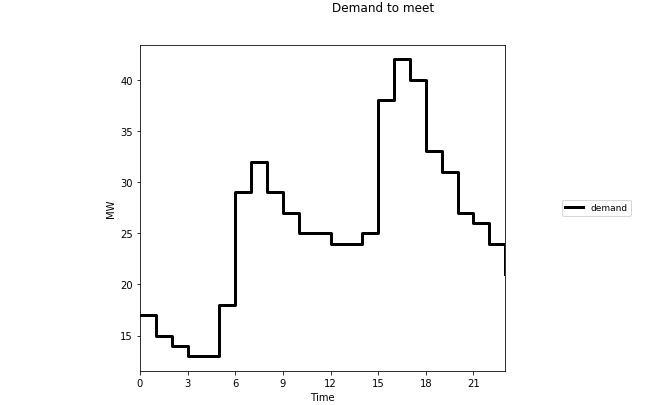

The values to respect for each time of day are as followed <br>
$[17, 15, 14, 13, 13, 18, 29, 32, 29, 27, 25, 25, 24, 24, 25, 38, 42, 40, 33, 31, 27, 26, 24, 21] (MW)$

In this project we will study the development of a **Mixed-Integer-Linear-Programming** (MILP) model to optimize the management of power assets to meet a specific demand.

The first section of the notebook presents the problem as well as the input data. In the second section we establish the model with the different variables and constraints associated to it. The third section presents the implementation in Guropipy and the visualisation of the data. Finally, we present in the last section improvements that can be made on the model.

This project was conducted during the Msc. in Energy Systems Optimization of Mines ParisTech in collaboration with Ms. [Simona MILADINOVA](https://fr.linkedin.com/in/simona-miladinova-839b8a17a/fr) and under the supervising of Ms. [Sophie DEMASSEY](http://sofdem.github.io/), associate professor at **Mines ParisTech**. This work resulted in a detailed report that is not presented in this notebook.

# Data

This input data is as follow. 

## **Thermal Power Plants**

We have at our disposal a total of three categories of thermal power plants. Each category has a specific number of units that must respect specific minimum and maximum power constraints. Here are the caracteristic of our thermal plant park.


Type | Number | Pmin | Pmax | Start Cost | Base Cost | Marginal Cost | 
:------: |:------:|:----:|:----:|:----------:|:---------:|:-------------:|
A      | 12       | 850  | 2000 | 2000       | 1000      |  2.0          |
B      | 10       | 1250 | 1750 | 1000       | 2600      |  1.3          |
C      | 5        | 1500 | 4000 | 500        | 3000      |  3            |

We have a total of 27 power plants : 12 of type A, 10 of type B, 5 of type C.

Definition of each caracteristics

- **Pmin (MW)**: Minimum power of a given unit for a given type.  <br>
- **Pmax (MW)**: Maximum power of a given unit for a given type. <br>
- **Start Cost (EUR)**: Cost of starting a unit for a given type <br>
- **Base Cost  (EUR)**: Cost of keeping ON a power plant. <br>
- **Marginal Cost (EUR)**: cost of each kwh produced

We will consider here that there aren't any cost related to stopping a power plant. 

## Hydroelectric powerplants

In addition to the existing thermal power plants, we have 2 hydroelectric plants that are available and supplied by a
the same reservoir. Since the capacity of the reservoir is not infinite, pumping from a nearby river must be done daily to keep the reservoir at the same level as the day before. The two hydroelectric power plants each have 4 possible operating levels each associated to a a lowering speed of the water tank. The pump in charge of maintaining the level of the reservoir will need an energy of 3000MWh to elevate of 1 meter the level of the reservoir.

Here the carateristics of each hydroelectric plant.

Hydroelectric 1

Floor   | Power  |Lowering Speed| Base Cost|
:------:|:------:|:------:|:------:|
1       |900     |0.31    |   90|
2       |950     |0.33    |95
3       |1000    |0.35    |105
4       |1100    |0.38    |120

Hydroelectric 2

Floor   | Power  |Lowering Speed| Base Cost|
:------:|:------:|:------:|:------:|
1       |1400     |0.47   | 90     |
2       |1500    |0.50    | 165    |
3       |1600    |0.53    |185     |
4       |1700    |0.56    |210     |

- Power **(MW)** : Power corresponding to an effective floor
- Lowering Speed **(m/h)**: Meter of height lost in the water tank at an effective floor
- Base Cost **(EUR/h)** : Coast of working at an effective floor

The Start Up Cost is not represented in the table but it is respectively **1500** and **1200** EUR for each hydro plant.<br>
Also, we would like to add that the change between to floor from one hour to another is considered instantaneous. 
Just like the thermal power plants, we consider that there aren't any cost related to stopping a power plant.


# Modelling of the different constraints

As explained in the introduction, The goal of the project is to be able to meet the demand with our electric park for each given timestep. Nonetheless, each of our power plants have constraints that limit their usage. 

The goal of this part is to go through the different constraints and present the selected modelling.
In this part we will enumerate the different constraints.


- Thermal plant must respect ther mimimum and maximal power when they are activated

- All cost must be integreted into the final model (Start, Base, Marginal)

- Only one floor of an hydro electric plant can be activated for a given timestep.

- The total water used for the hydroelectric plan must be restitued via the pump thoughout the same day

- The maximum capacity of each power plant (thermal and hydro) connected to the network must be able to respond to a rise of 15% in the demand.

## Variables

The variables retained for the model are the following

$y_{p,t,idx}$ : Power output of power plant ***idx*** of type ***t*** at timestep ***p*** <br>
$nb\_on_{p,t,idx}$ : Power plant ***idx*** of type ***t*** is ON at timestep ***p*** <br>
$nb\_start_{p,t,idx}$ : Power plant ***idx*** of type ***t*** is STARTED at timestep ***p*** <br>
$nb\_on_{p,h,pal}$ : Floor ***pal*** of hydroelectric plant ***h*** is ON at timestep ***p*** <br>
$nb\_start_{p,h,pal}$ : Floor ***pal*** of hydroelectric plant ***h*** is STARTED at timestep ***p*** <br>
$pmp_{p}$: Power output of pump reservoir at timestep ***p***

We have a total of **2352** variables for our model. The power variables are continuous and the others are binary.

Although it is not specified above, each variable has a lower bound of 0. Here are additional information on the variables.

- Timestep is 1 hour: **range of p is 24.**
- 3 types of thermal power plant: **range of t is 3**
- 2 types of hydroelectric plant: **range of h is 2** 
- For each one thermal plant 12, 10 and 8 units availble: **range of idx is either one of those.**
- 4 floors for each hydroelectric plant: **range of pal is 4**
- We only have 1 pump for the reservoir



$3*(24*(12+10+5)) + 2*(24*2*4) + 24 = 2352$ **variables**.

## Constraints

### Power limit

The first constraints is the power limit related to each power plant at timestep t

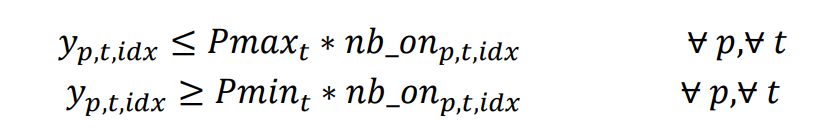




$Pmax_{t}$ : Maximum output of a power plant of type ***t***<br>
$Pmin_{t}$ : Minimum output of a power plant of type ***t***<br>

### Start-up variables

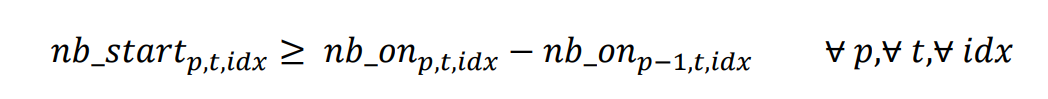

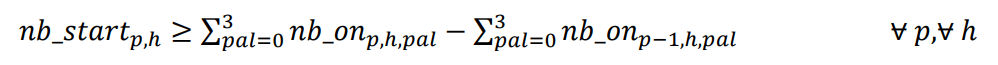

This constraints enables us to set nb_start at 1 each time a plant is activated is started.

### At most one floor selected for a given hydroelectric plant and timestep

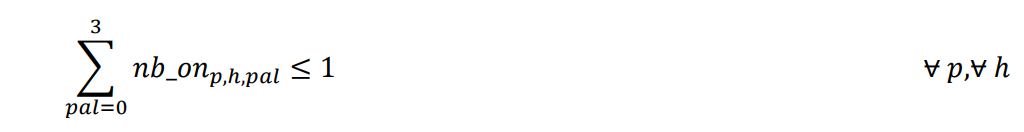

### Reserve constraints

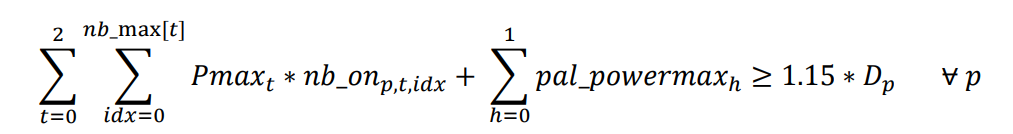

### Total turbined water is equal to total pumped water the end of the day.

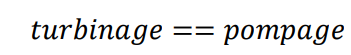

**With turbinage and pompage defined as follwed**

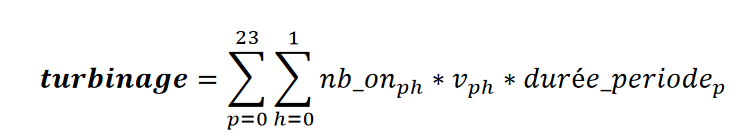

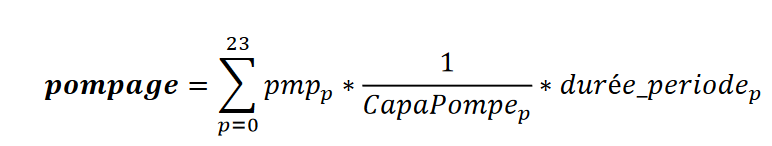

$v_{ph}$: Effective lowering speed of tank for a given hydroelectric plant<br>
$Durée\_periode$:timestep in hour<br>
$CapaPompe$: Energy required to elevate of 1 meter the level of water in the tank in MWh (in our case 3GWh)<br>

### Exlusion of turbining and pumping at the same timestep.

We use for this constraint the big M, method.

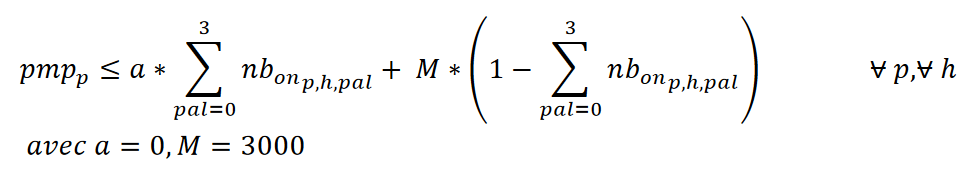

### Demand constraints

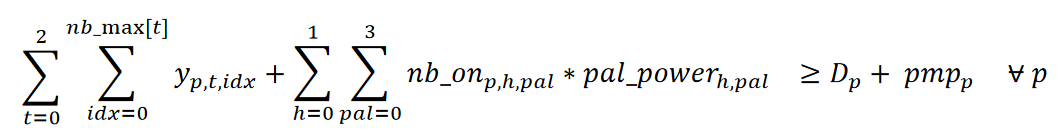

$pal\_power_{h,pal}$ : Effective floor of hydroelectric plant ***h***<br>
$nb\_max[t]$ : Total number of thermal power plants of type ***t***<br>
$D_p$: Demand required at timestep ***p***



# Cost function

As mentionned before, we have to minimize the operating cost of the electrical park to meet the demand. Therefore, we ought to include each cost associated to all 27 thermal plants and 2 hydroelectric plants in our objective function. The latter can thus be written as followed.

To simplify the writting we will divide our cost function into two terms: thermal and hydroelectric cost.

**Thermal cost**

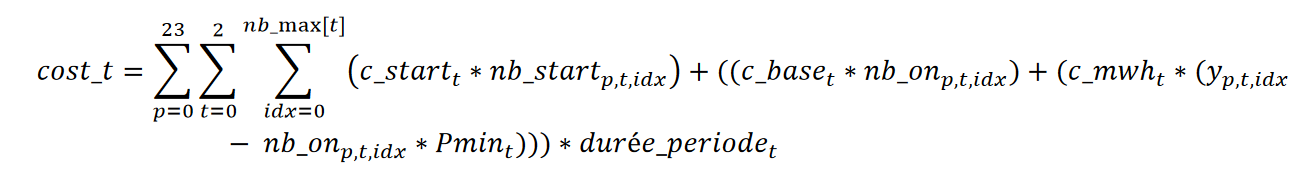

**Hydroelectric cost**

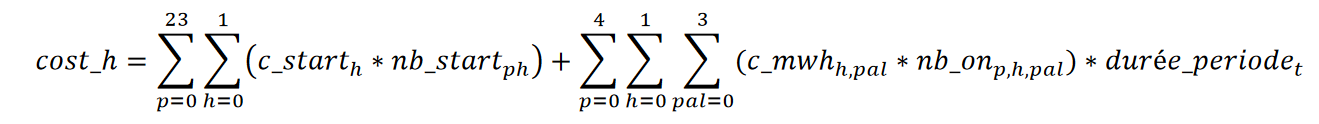

Our total cost function can thus be defined as

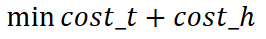

# Gurobipy code

Here is below the gurobiy code used for the optimization.

In [ ]:
model = Model()
model.modelSense = GRB.MINIMIZE

l = tuplelist([(t,p,idx) for t in category for idx in range(nb_max[t]) for p in iter_h]) # keys for thermal plants

# Ajout des variables
pw = model.addVars(l, vtype=GRB.CONTINUOUS, name="idv_centrale") # Thermal plan power
th_on = model.addVars(l, vtype=GRB.BINARY, name="binaire_centrale") # Thermal plant ON or OFF
th_start = model.addVars(l, vtype=GRB.BINARY, name="start_centrale_th") # Thermal plant started or not
ph_on = model.addVars(h_cat,nb_period_bis, pallier, vtype=GRB.BINARY, name="h") # Hydro with floors
h_start = model.addVars(h_cat, nb_period_bis,  vtype=GRB.BINARY, name="start_centrale_hy") # Hydro started or not
pmp = model.addVars(1, nb_period_bis,  vtype=GRB.CONTINUOUS, name="pompe") # Pump power


pw_therm = [pw.sum("*",p,"*") for p in iter_h] # Aggregate thermal power
pw_hydro = [quicksum(list_product(ph_on.select(h_t,p,"*"), h_pw[h_t].values()) for h_t in h_cat) for p in iter_h] # Aggregate hydro power
pw_pmp = [pmp.sum('*',p) for p in iter_h] 

# MAX MIN constraint
model.addConstrs((pw[t,p,idx] <= pmax[t]*th_on[t,p,idx] 
                  for t in category for idx in range(nb_max[t]) for p in iter_h),name="pmax")
model.addConstrs((pw[t,p,idx] >= pmin[t]*th_on[t,p,idx] 
                  for t in category for idx in range(nb_max[t]) for p in iter_h),name="pmin")

# Demand constraint
model.addConstrs((pw_therm[p] + pw_hydro[p] >= hour_dmd[p] + pw_pmp[p] 
                  for p in iter_h), name="load");

# Reserve constraint
res_t = [quicksum(pmax[t]*th_on[t,p,idx] for t in category for idx in range(nb_max[t])) for p in iter_h]
res_h = [quicksum(h_pw[h_t]["p4"] for h_t in h_cat) for p in iter_h]
model.addConstrs((res_t[p] + res_h[p] >= 1.15*hour_dmd[p] 
                  for p in iter_h), name="constr_reserve")

# Start constraint thermal
model.addConstrs((th_start[t,p,idx] >=  th_on[t,p,idx] - th_on[t,prev_bis(p),idx] 
                  for t in category for idx in range(nb_max[t]) for p in iter_h), 
                  name="start_th") 

# Start constraint hydro
model.addConstrs((h_start[h_t,p] >= quicksum(ph_on.select(h_t, p,"*")) - quicksum(ph_on.select(h_t,prev_bis(p),"*")) 
                 for p in iter_h for h_t in h_cat), name="start_hydro")
   
# Water tank constraint
tot_pmp = quicksum([pmp[0,p]*ts/e_pmp["pmp"] for p in iter_h])
tot_turb = quicksum(h_v[h_t][pal]*ph_on[h_t,p,pal]*ts 
                    for pal in pallier for h_t in h_cat for p in iter_h)    
const_niveau = model.addConstr(tot_turb==tot_pmp, name="egalite_reservoir")

# Floor constraint
model.addConstrs((quicksum(ph_on[h_t,p,pal] for pal in (pallier)) <= 1 
                  for p in iter_h for h_t in h_cat), name="nb_pallier")


# Exclusion pumping turbining
M = 3000
model.addConstrs(pmp[0,p] <= M*(1-quicksum(ph_on.select(h_t, p, "*"))) for p in iter_h for h_t in h_cat);

In [ ]:
cost_hydro = 0
for h_t in h_cat:
    cost_hydro += quicksum(list_product(ph_on.select(h_t,p, "*"),h_cost[h_t].values())*ts for p in iter_h)
cost_hydro += quicksum(h_start[t, p]*chstart[t] for t in h_cat for p in iter_h)
cost_thermique = quicksum((th_on[t,p,idx]*cbase[t] + (pw[t,p,idx]- pmin[t]*th_on[t,p,idx])*cadd[t])*ts + th_start[t,p,idx]*cstart[t] for t in category for idx in range(nb_max[t]) for p in iter_h)

model.setObjective(cost_thermique + cost_hydro);
model.params.mipgap = 1e-6;

model.update()
model.optimize()


# Final solution

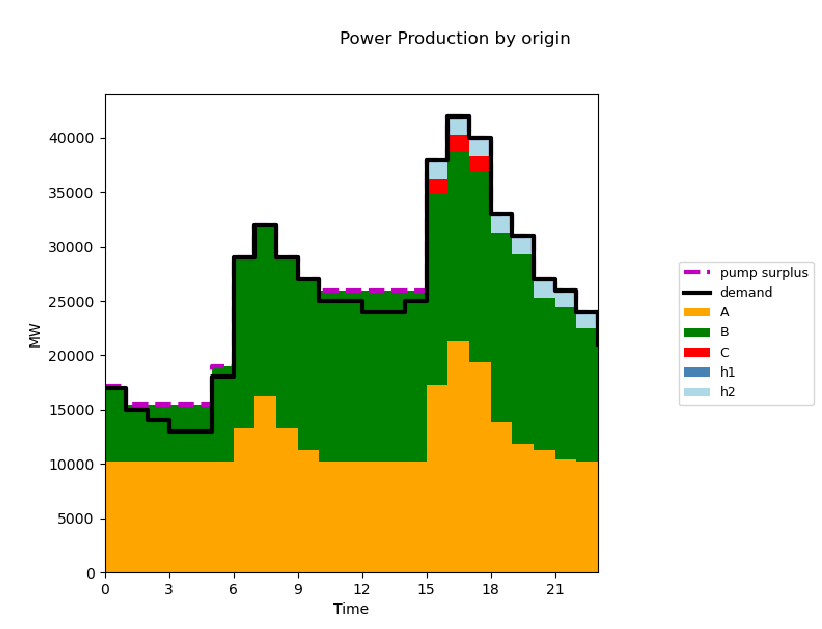

Optimal cost: **986.61 kEUR**

# Additonal constraints

On top of this optimal solution, additional constraints can be added to the problem in order comply with real-life constraints of operating power plants.

- Limit Start-up ramp as well as growth ramp
- Max stop ramp and power limit before stopping power plant

- Allow a maximum number or power plant of a given type ON during the night

- Impose a minimum lenght of maintenance and activity time during the day

As mentionned before, these constraints were implemented and are clearly explained in our project report. Additionaly, a complete sensitivity analysis as well as the impact of the various constraints was conducted.  

# References

References used to conduct the project :

* Sophie Demassey, (2021). *Linear Programming*. Mines Paristech
* Sophie Demassey, (2021). *Mixed Integer Linear Programming*. Mines Paristech
* D. Bertsimas & J.N. Tsitsiklis (1997). *Introduction to Linear Optimazation*.  Binding 

**Contact**:
- [Linkedin](https://fr.linkedin.com/in/seydou-dia-325b04139)<br>
- @:seydou.dia@mines-paristech.fr

**END OF NOTEBOOK**